# Time Series Analysis


## Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# plt.rcParams['figure.figsize']=(5,4)

import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
# os.getcwd()

In [4]:
# Load the data and set index to 'Day'
df = pd.read_csv('teleco_time_series.csv', index_col='Day', parse_dates=True)
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


In [5]:
df.shape

(731, 1)

In [6]:
# There are no null values or gaps in data in the series
df.isnull().any()

Revenue    False
dtype: bool

In [7]:
sum(df.duplicated())

0

## Line graph of the data

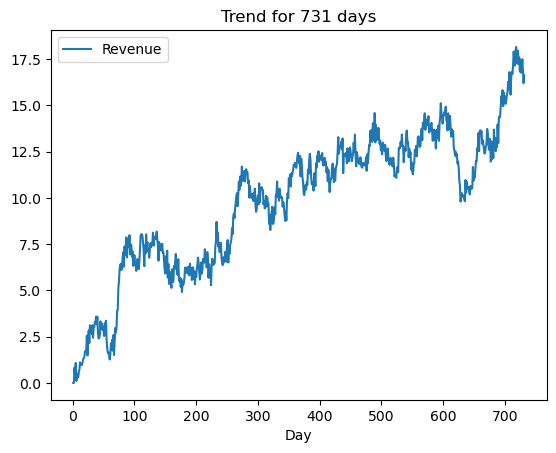

In [8]:
# Plot the data
df['Revenue'].plot(legend=True)
plt.title('Trend for 731 days');

## Evaluate the Stationarity

Below is the Dickey-Fuller test to evaluate stationarity, as well as rolling means. Both of these show the series is not stationary.

In [9]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

results = adfuller(df['Revenue'], autolag='AIC')
results

(-1.924612157310184,
 0.3205728150793963,
 1,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.0609576707513)

> The p_value is 0.32 which is bigger than 0.05, and the t-stat absolute value of 1.92 is less than absolute critical values, therefore we cannot reject the null hypothesis and state that the data is not stationary. 

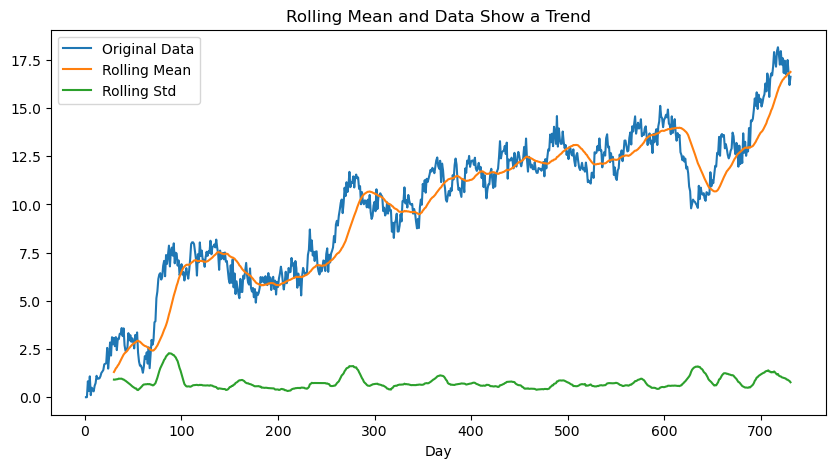

In [10]:
# Rolling mean and std for over 30 days
rolmean = df.rolling(window=30).mean() 
rolstd = df.rolling(window=30).std()

df['Revenue'].plot(figsize=(10,5), label='Original Data')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean and Data Show a Trend');

> Rolling mean following the trend shows the data is not stationary

### Take the diff() and run Dickey-Fuller test again

In [11]:
df2 = df.diff().dropna()
results2 = adfuller(df2['Revenue'])
results2

(-44.87452719387599,
 0.0,
 0,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 965.5032159185916)

> Now the p-value is < 0.05, and the t-stat is higher than critical values, we can reject the null and state the data is stationary

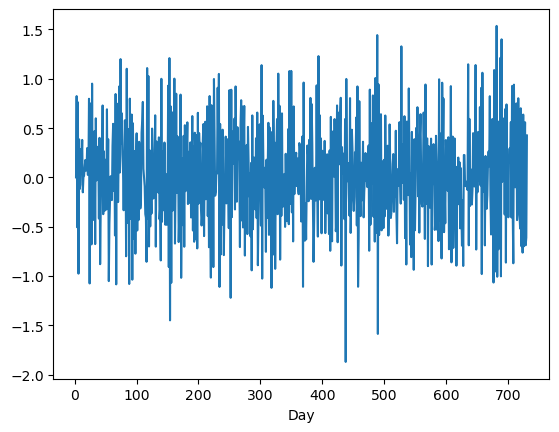

In [12]:
# Plot the data after diff()
df2['Revenue'].plot();

### Plot the differenced data with rolling mean and rolling standard deviation 

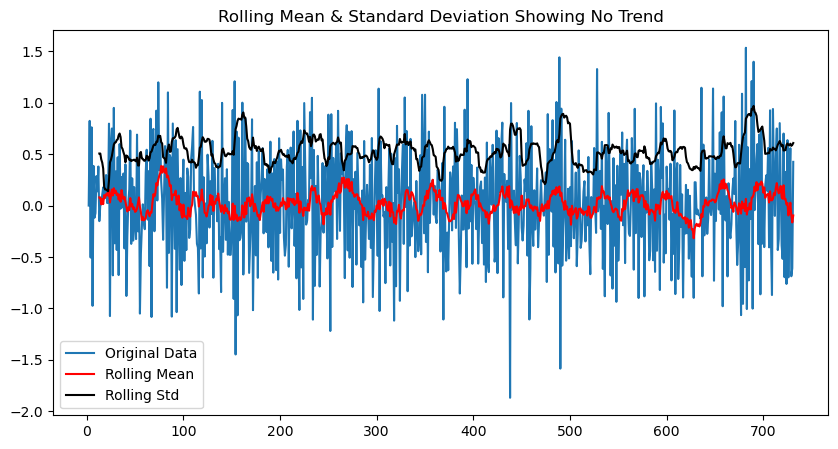

In [13]:
rolmean = df2.rolling(window=12).mean() # Monthly level
rolstd = df2.rolling(window=12).std()

plt.rcParams['figure.figsize']=(10,5)
orig = plt.plot(df2, label='Original Data')
mean = plt.plot(rolmean,  color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Showing No Trend')
plt.show();

> Rolling mean and the data is centered around 0, there is no trend. the data is stationary.

In [14]:
# Split data into train(18 months) and test(6 months)
train = df[:550]
test = df[550:]
len(train),len(test), len(df)

(550, 181, 731)

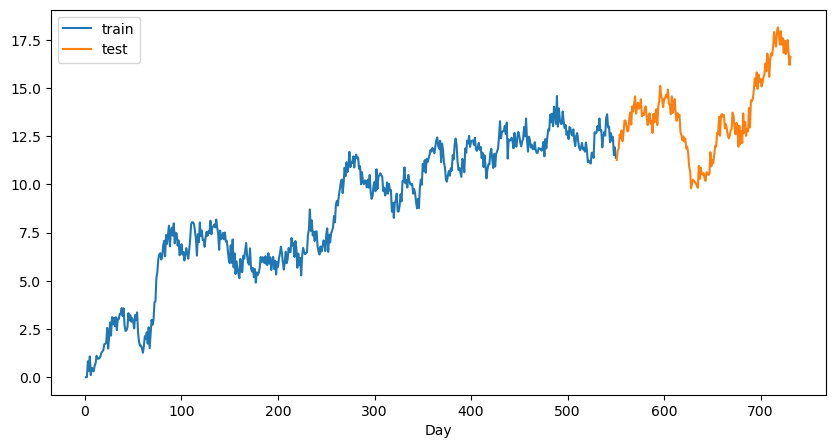

In [15]:
train['Revenue'].plot(label='train')
test['Revenue'].plot(label='test')
plt.legend()
plt.show();

## Copy of cleaned dataset

In [16]:
df2.to_excel('Differenced_data.xlsx')
train['Revenue'].to_excel('Train_data.xlsx')
test['Revenue'].to_excel('Test_data.xlsx')

# Model Indetification and Analysis

## Seasonal Component

In [17]:
# Decompose the data into original, trend, seasonal, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# There are 2 periods/years in the data
decomp = seasonal_decompose(df['Revenue'],  model='additive',period=2)

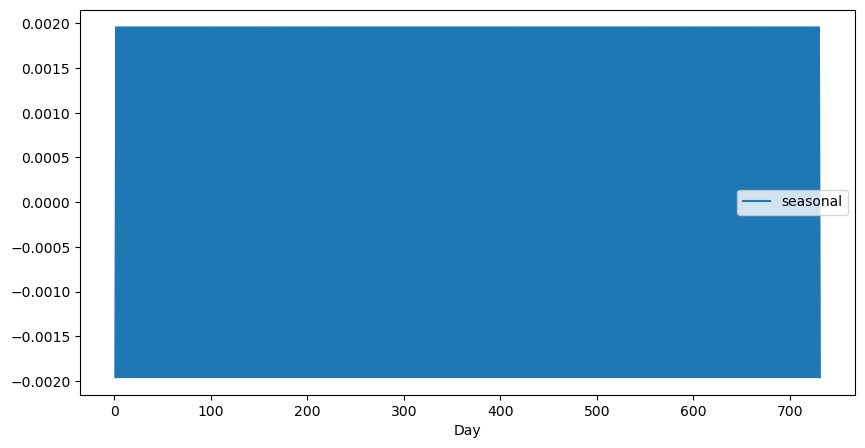

In [18]:
# Plot Seasonality
seasonal = decomp.seasonal
seasonal.plot(legend=True);

> There is no distinguishable seasonality.

## Trends

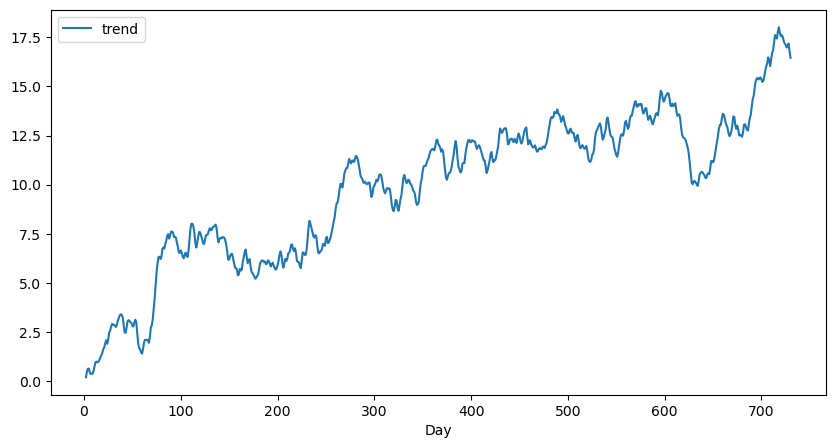

In [19]:
# Plot trend
trend= decomp.trend
trend.plot(legend=True);

> There is a visible upward trend, but no seasonal component to the data. 

## ACF and PACF before and after diff()

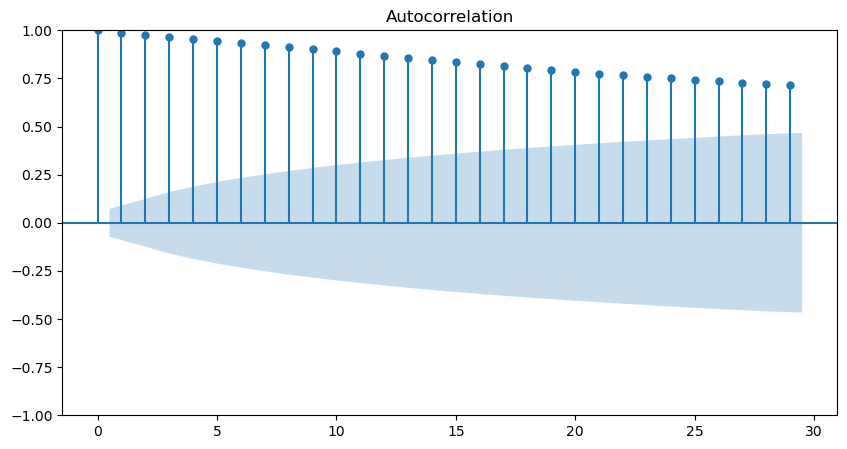

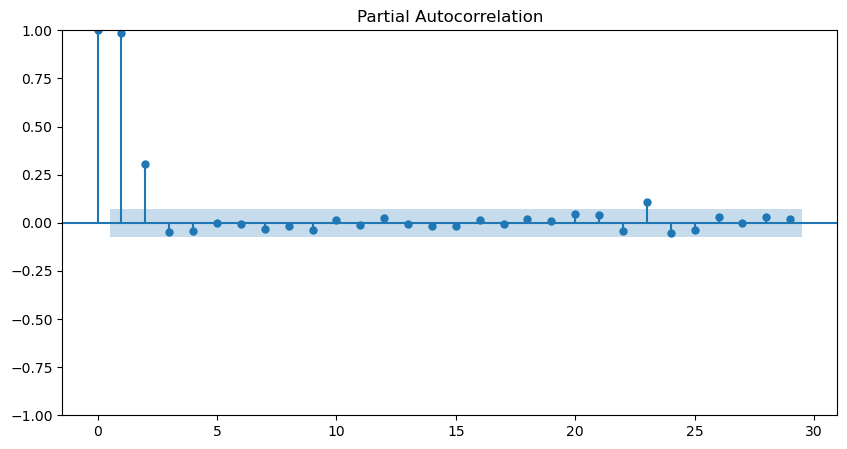

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF on original data
plot_acf(df);
plot_pacf(df);

> In the ACF plot there is a gradual decline showing the data is non-stationary. 

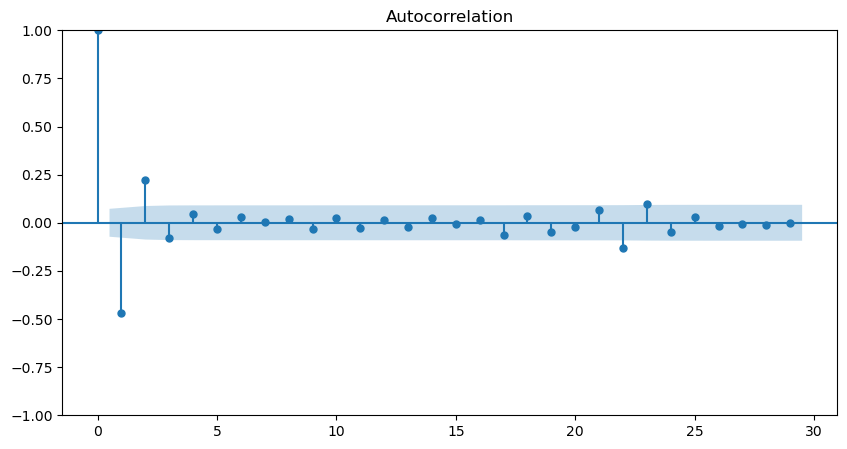

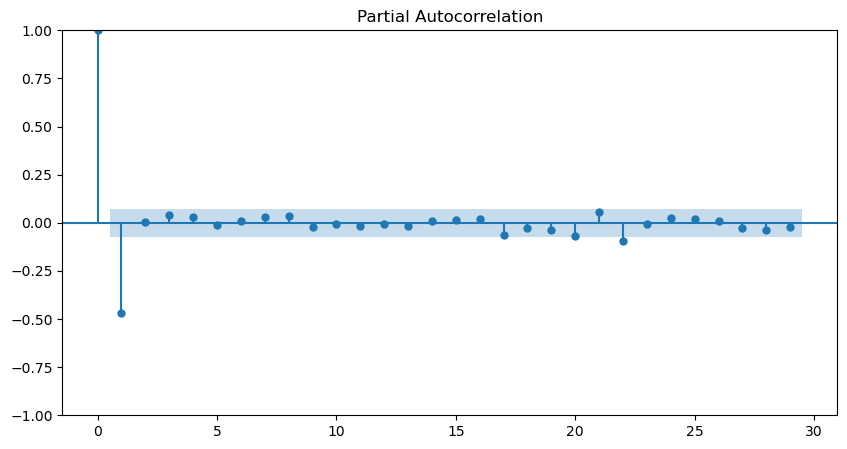

In [21]:
# Plot Autocorrelation and partial autocorrelation after differencing


plot_acf(df2);
plot_pacf(df2);

> ACF drops after two lags, showing the data is now stationary. Also, autocorrelation plots show the correlation at lag 1 and lag 2 which can be used for modeling. PACF plot corresponds to AR term p=1, ACF plot corresponds to MA term q=2. 

## Spectral Density

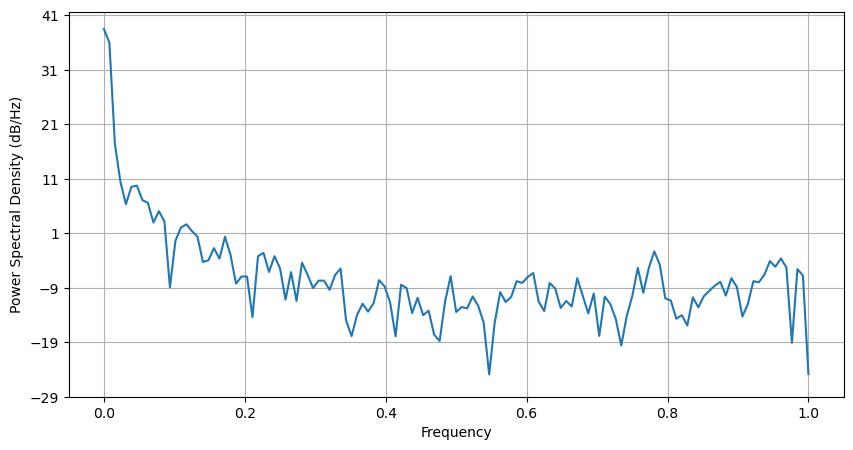

In [22]:
# Distribution of the energy of the frequencies
import matplotlib.gridspec as gridspec

plt.psd(df['Revenue'])
plt.show();

> There are no clear pattern of frequencies.

## Decomposing the timeseries

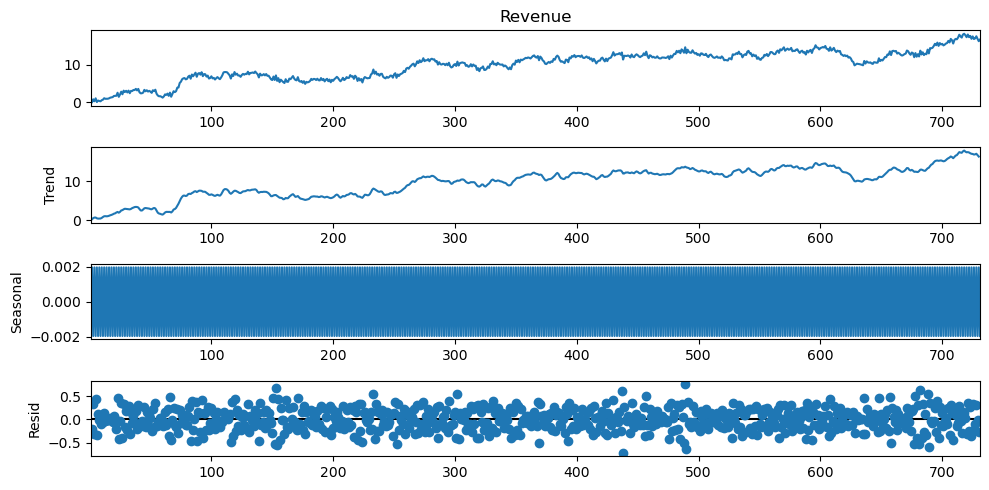

In [23]:
# Decompose the data into original, trend, seasonal, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# There are 2 periods/years in the data
decomp = seasonal_decompose(df['Revenue'],  model='additive',period=2)
decomp.plot();

## Residuals of the decomposed series

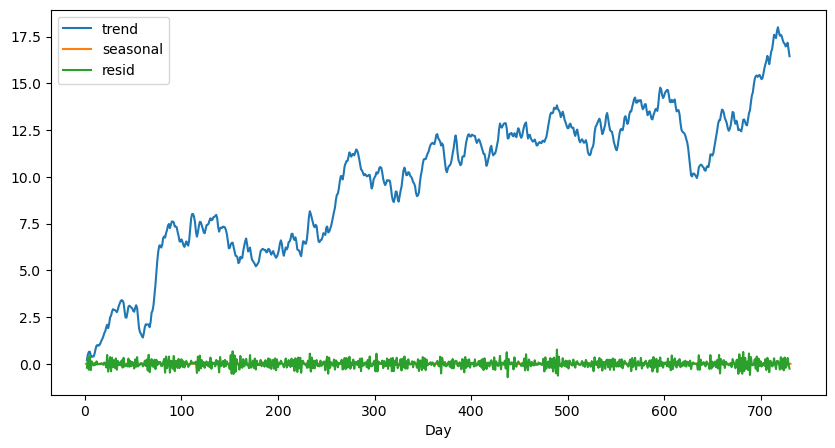

In [24]:
# Plot trend, seasonality, residuals
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

trend.plot(legend=True)
seasonal.plot(legend=True)
residual.plot(legend=True);

> There is an upward trend but no seasonality in the data. The residuals are hovering around zero with no trend, no autocorrelation.

##AUTO ARIMA on train data

In [25]:
# Using Auto ARIMA
from pmdarima import auto_arima
auto_1 = auto_arima(train['Revenue'], trace=True, suppress_warnings=True)
auto_1.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=735.992, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=866.115, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=732.393, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=760.261, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=864.953, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=734.349, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=734.358, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=735.801, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=732.770, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.608 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  550
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -363.196
Date:                Mon, 20 Mar 2023   AIC                            732.393
Time:                        19:02:32   BIC                            745.317
Sample:                             0   HQIC                           737.444
                                - 550                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0309      0.020      1.536      0.125      -0.009       0.070
ar.L1         -0.4680      0.037    -12.576      0.000      -0.541      -0.395
sigma2         0.2198      0.014     15.701      0.000       0.192       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.94   Prob(JB):                         0.55
Heteroskedasticity (H):               1.00   Skew:                            -0.06
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> Auto ARIMA indicates the best model is SARIMAX order (1,1,0), and there is no seasonality, even though our ACF/PACF plots gave the order of (1,1,2) for predicting modeling.

## ARIMA with (1,1,0)

In [26]:
# Run ARIMA on train data
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

model = ARIMA(train['Revenue'], order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  550
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -364.385
Date:                Mon, 20 Mar 2023   AIC                            732.770
Time:                        19:02:32   BIC                            741.386
Sample:                             0   HQIC                           736.138
                                - 550                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4656      0.037    -12.542      0.000      -0.538      -0.393
sigma2         0.2207      0.014     15.646      0.000       0.193       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.98   Prob(JB):                         0.55
Heteroskedasticity (H):               0.99   Skew:                            -0.06
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> Prob(Q) is 0.98, which is > 0.05, Prob(JB) is 0.55, which is also > 0.05. So we fail to reject the null which states the residuals are not correlated and normally distributed. 

In [27]:
results.fittedvalues

Day
1       0.000000
2       0.000000
3       0.000424
4       0.441532
5       0.555562
         ...    
546    12.441449
547    12.448528
548    12.373134
549    11.965228
550    11.736770
Length: 550, dtype: float64

In [28]:
# Calculate metrics of RMSE root mean squared error
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(train['Revenue'], results.fittedvalues))
rmse_train

0.46937847633736657

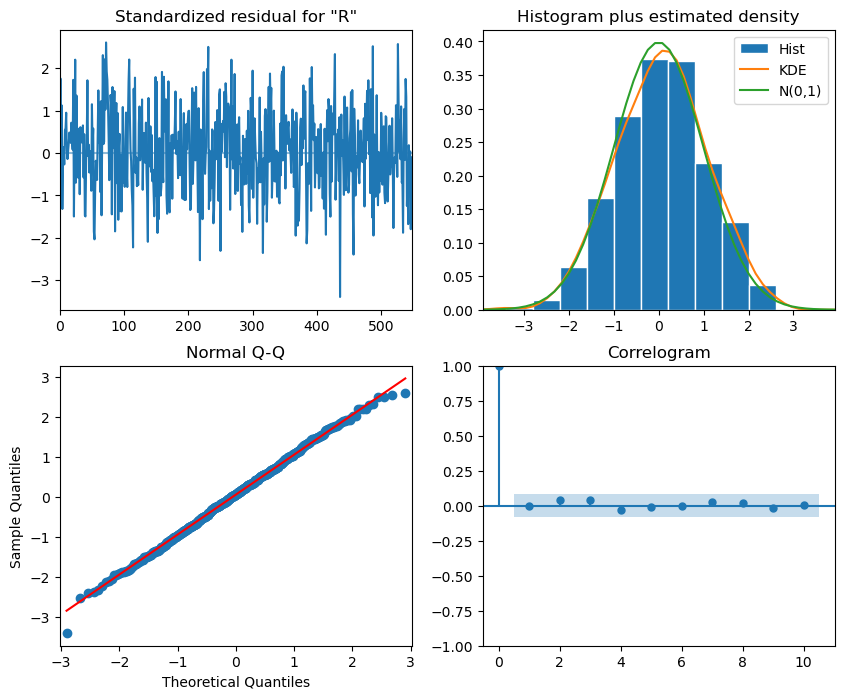

In [29]:
# Diagnostic Plots of the Residuals
results.plot_diagnostics(figsize=(10,8))
plt.show;

> The histogram of the residuals are normally distributed, most data lies on Q-Q Plot, and Correlogram shows no correlation among residuals. the model fits well.

## ARIMA with (1,1,2)

In [30]:
# Trying different ARIMA model based on ACF/PACF
model2 = ARIMA(train['Revenue'], order=(1,1,2))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  550
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -363.062
Date:                Mon, 20 Mar 2023   AIC                            734.123
Time:                        19:02:33   BIC                            751.356
Sample:                             0   HQIC                           740.858
                                - 550                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2644      0.166     -1.597      0.110      -0.589       0.060
ma.L1         -0.1953      0.166     -1.176      0.240      -0.521       0.130
ma.L2          0.1373      0.080      1.720      0.085      -0.019       0.294
sigma2         0.2196      0.014     15.396      0.000       0.192       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.90   Prob(JB):                         0.36
Heteroskedasticity (H):               1.00   Skew:                            -0.10
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> P-values are all higher than 0.05. They are not statistically significant. Also, AIC and BIC numbers are higher than the Auto ARIMA model. This is not a good model to use.

In [31]:
# Calculate metrics of RMSE root mean squared error
rmse_model2 = np.sqrt(mean_squared_error(train['Revenue'], results2.fittedvalues))
rmse_model2

0.46824876302062973

## Forecast based on AUTO ARIMA model (1,1,0)

In [32]:
model = ARIMA(train['Revenue'], trend='t', order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  550
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -363.196
Date:                Mon, 20 Mar 2023   AIC                            732.393
Time:                        19:02:33   BIC                            745.317
Sample:                             0   HQIC                           737.444
                                - 550                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0211      0.014      1.541      0.123      -0.006       0.048
ar.L1         -0.4680      0.037    -12.576      0.000      -0.541      -0.395
sigma2         0.2198      0.014     15.701      0.000       0.192       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.94   Prob(JB):                         0.55
Heteroskedasticity (H):               1.00   Skew:                            -0.06
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
df.tail()

,Revenue
Day,
727,16.931559
728,17.490666
729,16.803638
730,16.194813
731,16.620798


In [34]:
len(train), len(test)

(550, 181)

In [35]:
# Predict using Model with order (1,1,0) 

# Predict the length of the test
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True)

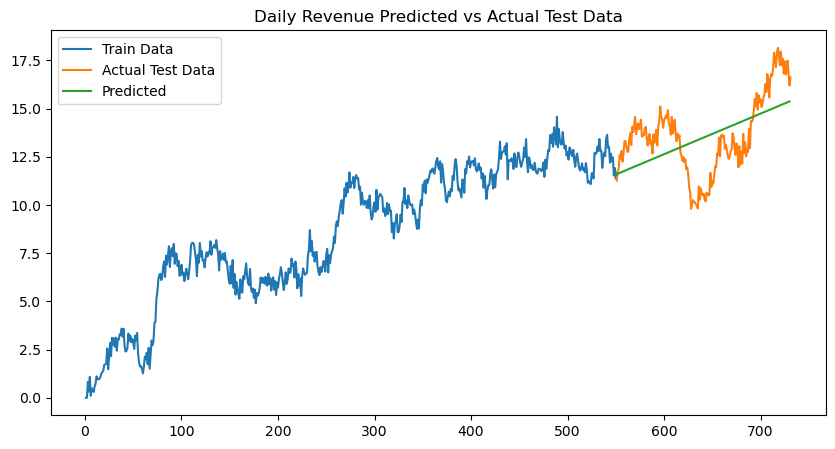

In [36]:
# plot the predictions along with train and test data for comparison
plt.plot(train['Revenue'],label='Train Data')
plt.plot(test['Revenue'], label='Actual Test Data')
plt.plot(predictions, label='Predicted')

plt.legend()
plt.title('Daily Revenue Predicted vs Actual Test Data')
plt.show();

In [37]:
len(predictions)

181

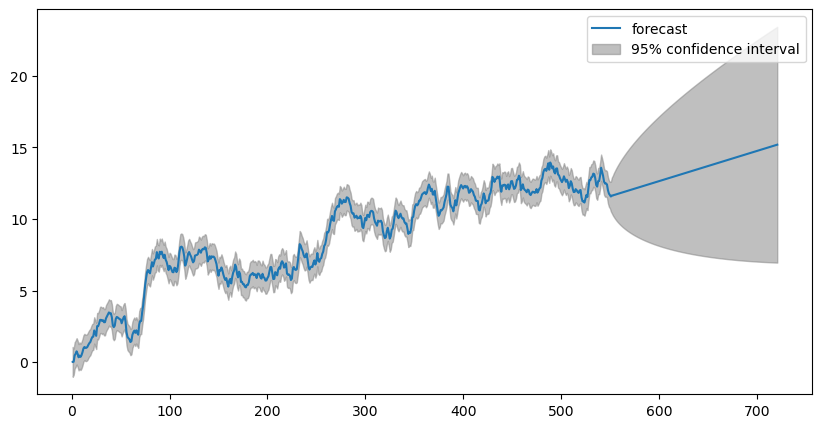

In [38]:
# Plotting prediction for 180 days
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(results, 1,721);

In [39]:
# Error Metric
rmse = np.sqrt(mean_squared_error(test['Revenue'], predictions))
rmse

1.7661729617273407

In [40]:
# Error Metric
mape = np.mean(abs((test['Revenue']-predictions)/test['Revenue']))*100
mape

11.987378037056295

> The average error (difference between actual and predicted revenue) is ~ 12%. And the average error in predicted revenue is 1.8 units off. 

##  Future Output

In [41]:
# Making predictions 6 months into the future
future = results.get_forecast(steps=360)
mean_future = future.predicted_mean
mean_future

550    11.663595
551    11.562825
552    11.640906
553    11.635286
554    11.668837
         ...    
905    19.058171
906    19.079235
907    19.100298
908    19.121362
909    19.142425
Name: predicted_mean, Length: 360, dtype: float64

In [42]:
# Put predictions and data together
df_pred = pd.concat([df, mean_future.to_frame()])
df_pred

,Revenue,predicted_mean
1,0.000000,NaN
2,0.000793,NaN
3,0.825542,NaN
4,0.320332,NaN
5,1.082554,NaN
...,...,...
905,NaN,19.058171
906,NaN,19.079235
907,NaN,19.100298
908,NaN,19.121362


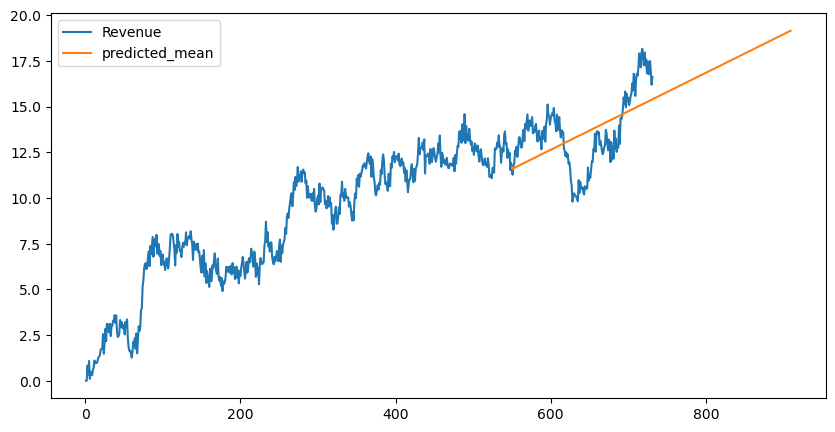

In [43]:
df_pred.plot();

In [44]:
# confidence_intervals = future.conf_int(alpha=0.05)
# lower_limits = confidence_intervals.loc[:,'lower Revenue']
# upper_limits = confidence_intervals.loc[:,'upper Revenue']

In [45]:
# lower_limits,upper_limits

## Visualization of the forecast of final model

In [47]:
# Making predictions 6 months into the future
future = results.get_forecast(steps=360)
mean_future = future.predicted_mean

In [48]:
# Get the confidence intervals of the predictions
confidence_intervals = future.conf_int(alpha=0.05)
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

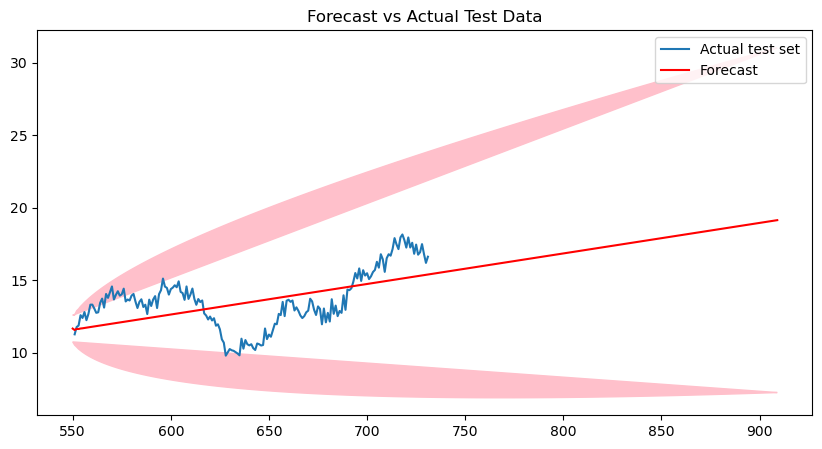

In [49]:
# Plot the Actual Test Data vs Forecast with confidence intervals
plt.plot(test['Revenue'], label= 'Actual test set')
plt.plot(mean_future, label='Forecast', color='red')
plt.fill(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('Forecast vs Actual Test Data')
plt.legend()
plt.show;